In [1]:
import pandas as pd
import numpy as np
import os
import random
from abc import ABCMeta, abstractmethod
from tqdm.notebook import tqdm

In [2]:
df_guests = pd.read_csv("guests.csv")
df_hotels = pd.read_csv("hotels.csv")
df_prefs = pd.read_csv("preferences.csv")

In [57]:
class BaseAllocation(metaclass=ABCMeta):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        
        # Create a column based on the position of guest and hotel in the table [0, len of table-1]
        df_guests = df_guests.reset_index().rename(columns={'index': 'guest_index'})
        df_hotels = df_hotels.reset_index().rename(columns={'index': 'hotel_index'})
        
        df_preferences = df_preferences.merge(df_guests[['guest', 'guest_index']], on='guest')
        df_preferences = df_preferences.merge(df_hotels[['hotel', 'hotel_index']], on='hotel')
        
        self.guests = df_guests
        self.hotels = df_hotels
        self.preferences = df_preferences
        
        self.number_hotel = len(df_hotels)
        self.number_guest = len(df_guests)
        
          
        # initialize the preferences matrix (# guest, # hotel) where 0 if the guest is not assigned to the specific hotel and 1 if he is assigned
        self.pref_matrix = np.zeros((self.number_guest, self.number_hotel))
        
        # initialize the hotel availability rooms matrix column 1 -> room availability, column 2 -> price, column 3 -> number of rooms assign 
        hotel_matrix = df_hotels.drop(columns=['hotel']).set_index("hotel_index").values
        self.hotel_matrix = np.c_[hotel_matrix, np.zeros(self.number_hotel)]
        
        # initialize stats
        self.df_pref_matrix = None
        self.df_hotel_matrix = None
        
        self.flag_stats = False  # True if called self._compute_stats()
        self.satifaction_level = None
        self.business_volume = None
        self.number_ass_guest = None
        self.number_vacant_rooms = None
        self.number_fully_book_hotels = None
        self.number_empty_hotels = None
        self.number_not_full_empty_hotel = None


    def _preprocessing_results(self):
        # Trova il massimo indice (index dell'hotel) per colonna per ogni guest. Se il guest non è stato assegnato viene generato un indice non indicato nelle tabelle degli hotel
        df_pref_matrix = pd.DataFrame(np.argmax(np.c_[self.pref_matrix, np.array([1]*self.number_guest,)], axis=1), columns=['hotel_index'])
        df_pref_matrix = df_pref_matrix.reset_index().rename(columns={'index': 'guest_index'})

        # # Assegno sconto per ogni cliente
        df_pref_matrix = df_pref_matrix.merge(self.guests, on='guest_index')

        # # Assegno prezzo per ogni hotel e filtra via i guest che non hanno una prenotazione (non trova hotel con ID 400)
        df_pref_matrix = df_pref_matrix.merge(self.hotels.drop(columns=["rooms"]), on='hotel_index')

        # # Calcola il prezzo da applicare ad ogni guest
        df_pref_matrix['price_to_set'] = df_pref_matrix.price * (1 - df_pref_matrix.discount)

        # # Trasformiamo hotel_matrix in un dataframe per calcolare numero di hotel liberi/pieni
        self.df_hotel_matrix = pd.DataFrame(self.hotel_matrix, columns=['rooms', 'price', 'occupied_rooms'])
        
        df_pref_matrix = df_pref_matrix.merge(self.preferences[["guest_index", "hotel_index", "priority"]], on=["guest_index", "hotel_index"])
        df_pref_matrix['priority'] = df_pref_matrix['priority'] - 1

        number_of_priority = self.preferences.groupby("guest_index", as_index=False)['priority'].count().rename(columns={'priority': 'number_of_priority'})
        df_pref_matrix = df_pref_matrix.merge(number_of_priority, on='guest_index')

        df_pref_matrix['satisfaction'] = (df_pref_matrix.number_of_priority - df_pref_matrix.priority)/df_pref_matrix.number_of_priority
        
        self.df_pref_matrix = df_pref_matrix
            
    
    def _compute_stats(self):
        
        self._preprocessing_results()
        
        self.satifaction_level = self.df_pref_matrix.satisfaction.sum() / self.number_guest
        self.business_volume = self.df_pref_matrix.price_to_set.sum()
        self.number_ass_guest = len(self.df_pref_matrix)
        self.number_vacant_rooms = self.hotels.rooms.sum() - self.number_ass_guest
        self.number_fully_book_hotels = len(self.df_hotel_matrix[(self.df_hotel_matrix['rooms'] == self.df_hotel_matrix['occupied_rooms'])])
        self.number_empty_hotels = len(self.df_hotel_matrix[(self.df_hotel_matrix['occupied_rooms'] == 0)])
        self.number_not_full_empty_hotel = self.number_hotel - self.number_fully_book_hotels - self.number_empty_hotels
        
        self.flag_stats = True
        
          
    def __str__(self):
        if self.flag_stats:
            result = [
                f'Total business volume: {round(self.business_volume, 2):,} €',
                f'Assigned guests: {self.number_ass_guest}',
                f'Vacant rooms: {self.number_vacant_rooms}',
                f'Number of fully booked hotels: {self.number_fully_book_hotels}',
                f'Number of completely vacant hotels: {self.number_empty_hotels}',
                f'Number of neither full nor vacant hotels: {self.number_not_full_empty_hotel}',
                f'Overall satisfaction is: {round(self.satifaction_level*100, 2)}%'
            ]
            return '\n'.join(result)
        else:
            return "Not available statistics. Launch the method assign()"
   
    
    def _access_pref_matrix(self, guest, hotel):
        self.pref_matrix[guest, hotel] = 1
        self.hotel_matrix[hotel, 2] += 1
        
    
    @abstractmethod
    def assign(self):
        pass

In [62]:
class GuestAllocation(BaseAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(GuestAllocation, self).__init__(df_guests, df_hotels, df_preferences)
    
    @abstractmethod
    def _define_guest_order(self):
        pass
        
    # todo -> Controllare script    
    def assign(self): 
        guest_order = self._define_guest_order()
        for guest in guest_order:
            for hotel in self.pref_by_guest[guest]:
                if self.hotel_matrix[hotel, 2] < self.hotel_matrix[hotel, 0]:
                    self._access_pref_matrix(guest, hotel)
                    break
        self._compute_stats()


In [66]:
class HotelAllocation(BaseAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(HotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
            
    @abstractmethod
    def _define_hotel_order():
        pass
    
    def assign(self):
        hotel_order = self._define_hotel_order()
        for hotel in hotel_order:
            for guest in self.guest_by_hotel[hotel]:
                if self.hotel_matrix[hotel, 2] == self.hotel_matrix[hotel, 0]:
                    break
                elif self.pref_matrix[guest,:].sum() == 0:
                    self._access_pref_matrix(guest, hotel)
        self._compute_stats()

In [67]:
class RandomGuestAllocation(GuestAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(RandomGuestAllocation, self).__init__(df_guests, df_hotels, df_preferences)
                
    def _define_guest_order(self):
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {0: [21, 32, 65, ...], 1: [...], ...}
        self.pref_by_guest = self.preferences.groupby("guest_index").agg({"hotel_index":list}).to_dict()["hotel_index"]
        return random.sample(list(self.pref_by_guest.keys()), len(self.pref_by_guest))


In [64]:
a = RandomGuestAllocation(df_guests, df_hotels, df_prefs)
a.assign()

In [ ]:
a.df_

In [89]:
p = df_prefs.groupby(["guest", "hotel"])['priority'].count()

p[p>1]

In [ ]:
df_prefs

In [83]:
df_prefs[df_prefs.guest=='guest_2980'].sort_values(['hotel'])

,guest,hotel,priority
73546,guest_2980,hotel_1,22
73550,guest_2980,hotel_115,26
73569,guest_2980,hotel_127,45
73542,guest_2980,hotel_127,18
73560,guest_2980,hotel_14,36
73556,guest_2980,hotel_15,32
73544,guest_2980,hotel_156,20
73558,guest_2980,hotel_157,34
73541,guest_2980,hotel_160,17
73568,guest_2980,hotel_165,44


In [76]:
a.df_pref_matrix[a.df_pref_matrix.duplicated("guest", keep=False)]

,guest_index,hotel_index,guest,discount,hotel,price,price_to_set,priority,number_of_priority,satisfaction
26,2979,48,guest_2980,0.08,hotel_49,50,46.00,0,45,1.000000
27,2979,48,guest_2980,0.08,hotel_49,50,46.00,7,45,0.844444
54,10,25,guest_11,0.00,hotel_26,55,55.00,21,39,0.461538
55,10,25,guest_11,0.00,hotel_26,55,55.00,37,39,0.051282
60,1281,25,guest_1282,0.12,hotel_26,55,48.40,18,40,0.550000
...,...,...,...,...,...,...,...,...,...,...
3933,3649,150,guest_3650,0.11,hotel_151,183,162.87,32,46,0.304348
3991,2578,356,guest_2579,0.13,hotel_357,176,153.12,7,39,0.820513
3992,2578,356,guest_2579,0.13,hotel_357,176,153.12,10,39,0.743590
4001,3884,165,guest_3885,0.02,hotel_166,236,231.28,18,49,0.632653


In [65]:
print(a)

Total business volume: 651,390.59 €
Assigned guests: 4035
Vacant rooms: 582
Number of fully booked hotels: 321
Number of completely vacant hotels: 13
Number of neither full nor vacant hotels: 66
Overall satisfaction is: 54.65%


In [68]:
class OrderGustAllocation(GuestAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(OrderGustAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
        
    def _define_guest_order(self):
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {0: [21, 32, 65, ...], 1: [...], ...}
        self.pref_by_guest = self.preferences.groupby("guest_index").agg({"hotel_index":list}).to_dict()["hotel_index"]
        return sorted(self.pref_by_guest.keys())


In [69]:
class PriceHotelAllocation(HotelAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(PriceHotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
    def _define_hotel_order(self):  
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {21: [0, 2, 5, ...], 65: [...], ...}
        guest_by_hotel = self.preferences.groupby("hotel_index").agg({"guest_index":list}).to_dict()["guest_index"]
        self.guest_by_hotel = {key: sorted(values) for key, values in guest_by_hotel.items()}
        
        return self.hotels.sort_values('price')['hotel_index'].tolist()
    

In [70]:
class AvailabilityHotelAllocation(HotelAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(AvailabilityHotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
    def _define_hotel_order(self): 
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {21: [0, 2, 5, ...], 65: [...], ...}
        guest_by_hotel = self.preferences.groupby("hotel_index").agg({"guest_index":list}).to_dict()["guest_index"]
        self.guest_by_hotel = {key: sorted(values) for key, values in guest_by_hotel.items()}
        
        return self.hotels.sort_values('rooms', ascending=False)['hotel_index'].tolist()
    

In [13]:
metric = list()
for i in tqdm(range(1000)):
    a = RandomGuestAllocation(df_guests, df_hotels, df_prefs)
    a.assign()
    metric.append(a.pref_matrix.sum(1).sum())

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:>

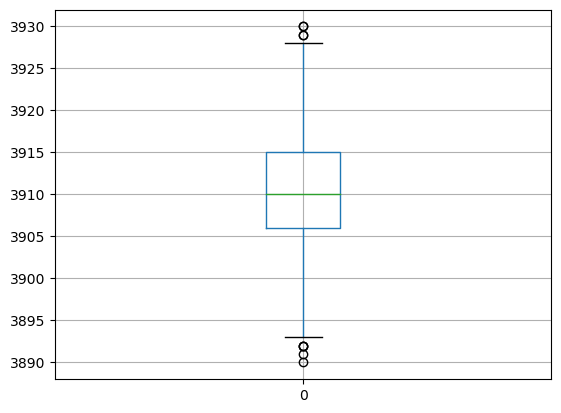

In [14]:
pd.DataFrame(metric).boxplot()

In [71]:
b = OrderGustAllocation(df_guests, df_hotels, df_prefs)
b.assign()
b.pref_matrix.sum(1).sum()

3926.0

In [72]:
print(b)

Total business volume: 653,547.55 €
Assigned guests: 4045
Vacant rooms: 572
Number of fully booked hotels: 323
Number of completely vacant hotels: 9
Number of neither full nor vacant hotels: 68
Overall satisfaction is: 55.56%


In [11]:
c = PriceHotelAllocation(df_guests, df_hotels, df_prefs)

c.assign()

c.pref_matrix.sum(1).sum()

3925.0

In [10]:
d = AvailabilityHotelAllocation(df_guests, df_hotels, df_prefs)

d.assign()

d.pref_matrix.sum(1).sum()

3954.0